In [1]:
from importlib import reload
#from __future__ import print_function
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten,Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.utils.np_utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Import the data.

In [2]:
train = pd.read_csv('../input/train.csv')
train.head()
print('training data is (%d, %d).'% train.shape)

training data is (42000, 785).


Let's split the training set into 2, training set and validation set. This is done with `train_test_split` in `sklearn` module.

In [3]:
X_train_all = (train.iloc[:,1:].values).astype('float32')/255 # all pixel values, convert to value in [0,1]
y_train_all = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
y_train_all= to_categorical(y_train_all) # This convert y into onehot representation
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.10, random_state=42)

We have to map the image vectors (size 784) back to image. Specially, we have to convert to (28,28,1), since the convoluation layer of Kares only accept image of dimension 3 (the last dimension is the color channel).

In [4]:
X_train_img=np.reshape(X_train,(X_train.shape[0],28,28,1))
X_val_img = np.reshape(X_val,(X_val.shape[0],28,28,1))

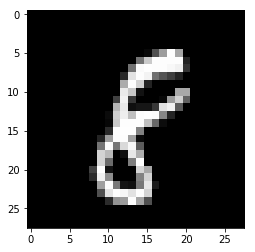

In [5]:
plt.imshow(X_train_img[0,:,:,0],cmap = 'gray')
plt.show()

## 2. A Typical CNN structure: one CNN layer.

We are going to setup the following CNN model. Basically: input layer --> CNN layer --> softmax layer

### 1. Input layer: 
The original input image is `28 x 28`, so the `input_shape=(28,28,1)`, where `1` indicates that number of color channels is 1. 
 
### 2. Convolution layer:
 In the following convolution layer, there are 32 filters, and each filters is `3 x 3`.
  * You can set border differently by:
       ```
       border_mode='same', 'fall', or 'valid' (default)
       ```
  * With `valid` border, after convolution (with stride=0), the filted image (AKA **feature map**) size is `(28-2) x (28-2) = 26 x 26` . Note there are 32 feature maps.
    
  * Set **stride** 2 by `strides=(2,2)`. The stride action will skip one pixel (both vertically and horizontally) while applying convolution. So now the every feature map (the filtered and subsampled image) is `13 x 13`
 
  * There are $$32\cdot3\cdot3+32 =320$$ parameters:
     - Each "pixel" of a feature map is obtained by $$\sum_{i=1}^9 w_i x_i +b,$$ where $$w_1,...,w_9,b\in \mathbb{R}^{10}$$ are parameters and $$(x_1,...,x_9)$$ are pixel values of a `3 x 3` image patches, AKA **receptive field**, in the original input image.
   
  * Using `relu` units by `activation='relu'`, then max Pooling by 2. So the output of this CNN layer will be 32 of `6 x  6` "images".
   
### 3. Flatten layer:
 one has to 'flatten' the output of the CNN layer before applying softmax layer. After flatten, the input of the next layer is of $$6\cdot 6\cdot 32=1152$$ values.
 
### 4. Softmax layer:
So the last layer ('softmax') would require $$1152\cdot 10+10=11530$$ parameters.


In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3),
                 activation='relu',
                 input_shape=(28,28,1),strides=(2,2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten(name='flatten'))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                11530     
Total params: 11,850
Trainable params: 11,850
Non-trainable params: 0
_________________________________________________________________


Before fitting the parameters, we need to compile the model first.

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

In [8]:
batch_size = 64 
nb_epochs = 5 
history = model.fit(X_train_img, y_train,
                    batch_size=batch_size,
                    epochs=nb_epochs,
                    verbose=2, 
                    validation_data=(X_val_img, y_val),
                    initial_epoch=0)

Train on 37800 samples, validate on 4200 samples
Epoch 1/5
5s - loss: 0.5229 - acc: 0.8588 - val_loss: 0.2714 - val_acc: 0.9190
Epoch 2/5
4s - loss: 0.2140 - acc: 0.9390 - val_loss: 0.1999 - val_acc: 0.9405
Epoch 3/5
5s - loss: 0.1528 - acc: 0.9556 - val_loss: 0.1494 - val_acc: 0.9560
Epoch 4/5
4s - loss: 0.1244 - acc: 0.9639 - val_loss: 0.1350 - val_acc: 0.9602
Epoch 5/5
4s - loss: 0.1076 - acc: 0.9685 - val_loss: 0.1166 - val_acc: 0.9655


We can see that after 20 epoch, the validation accuracy is not improved (around 97.6%). The training set accuracy is about 98.8%. We should first try more complicated model to see if the training set accuracy get higher.

In [9]:
model = Sequential()
model.add(Conv2D(64, (5, 5),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))   
model.add(Flatten(name='flatten'))
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 11, 11, 128)       4224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                154890    
Total para

In [10]:
batch_size = 64
nb_epochs = 2
history = model.fit(X_train_img, y_train,
                    batch_size=batch_size,
                    epochs=nb_epochs,
                    verbose=2, # verbose controls the infromation to be displayed. 0: no information displayed
                    validation_data=(X_val_img, y_val),
                    initial_epoch=0)


Train on 37800 samples, validate on 4200 samples
Epoch 1/2
251s - loss: 0.1644 - acc: 0.9492 - val_loss: 0.0698 - val_acc: 0.9798
Epoch 2/2
193s - loss: 0.0594 - acc: 0.9821 - val_loss: 0.0723 - val_acc: 0.9774


In [11]:
test = pd.read_csv('../input/test.csv')
X_test = (test.values).astype('float32')/255 # all pixel values
X_test_img = np.reshape(X_test,(X_test.shape[0],28,28,1))

In [12]:
pred_classes = model.predict_classes(X_test_img,verbose=0)

Take a look at what we predicted on a test sample.

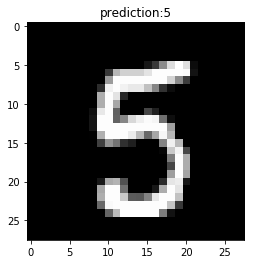

In [13]:
i=10
plt.imshow(X_test_img[i,:,:,0],cmap='gray')
plt.title('prediction:%d'%pred_classes[i])
plt.show()

In [14]:
def plot_difficult_samples(model,x,y, verbose=True):
    """
    model: trained model from keras
    x: size(n,h,w,c)
    y: is categorical, i.e. onehot, size(n,10)
    """ 
    #%%
    
    pred_classes = model.predict_classes(x,verbose= 0)
    y_val_classes = np.argmax(y, axis=1)
    er_id = np.nonzero(pred_classes!=y_val_classes)[0]
    #%%
    K = np.ceil(np.sqrt(len(er_id)))
    fig = plt.figure()
    print('There are %d wrongly predicted images out of %d validation samples'%(len(er_id),x.shape[0]))
    for i in range(len(er_id)):
        ax = fig.add_subplot(K,K,i+1)
        k = er_id[i]
        ax.imshow(x[er_id[i],:,:,0])
        ax.axis('off')
        if verbose:
            ax.set_title('%d as %d'%(y_val_classes[k],pred_classes[k]))

There are 95 wrongly predicted images out of 4200 validation samples


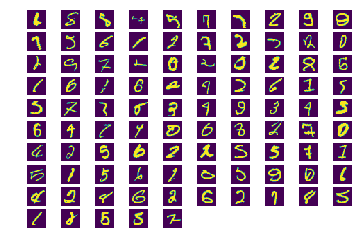

In [15]:
plot_difficult_samples(model,X_val_img,y_val,verbose=False)
plt.show()